# Checking the Lookup table and finding most optimum way of reading it
## Overall Conclusion: Interpolation in w helps bringing avg. computation time down to ~0.002 s !!!

In [2]:
#!/home/anuj.mishra/anaconda3/envs/gwpy/bin/python

import numpy as np

import sys
import mpmath
from mpmath import hyp1f1
import math
import scipy
from scipy.interpolate import interp1d
import pandas as pd

from copy import deepcopy

from itertools import product
from functools import partial
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import pickle

sys.path.append('../src/')
import pnt_lens_class 
pnt_lens_py = pnt_lens_class.point_lens()

# loading Cython version of the point lens class
import cythonized_pnt_lens_class as pnt_lens_cy
   
    

## 1. Loading lookup table and reconstructing the grid form the data

In [5]:
import pickle

outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0'

with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)

print('\nNumber of entries in lookup_table: ', len(Ff_grid)) 
Ff_grid[str(0)]


Number of entries in lookup_table:  35000


{'y': 0.01,
 'ws': array([1.00000000e-04, 1.00311921e-04, 1.00624816e-04, ...,
        1.29192783e+04, 1.29595763e+04, 1.30000000e+04]),
 'Ffs_real': array([ 1.00007841,  1.00007865,  1.0000789 , ..., 12.02985878,
        14.14185837, 11.91298484]),
 'Ffs_imag': array([-5.15356541e-04, -5.16807959e-04, -5.18263418e-04, ...,
        -5.01931555e+00,  7.88613724e-02,  5.14481310e+00])}

In [4]:
len(Ff_grid['0']['ws'])

6000

In [414]:
ysg = np.array([Ff_grid[str(i)]['y'] for i in range(len(Ff_grid))])
wsg = Ff_grid['0']['ws']

ys = np.logspace(-2, np.log10(5), 35000)
ws = np.logspace(-4, np.log10(1.3e4), 6000)

In [415]:
print(np.allclose(ws, wsg, rtol=1e-10, atol=1e-10))
print(np.allclose(ys, ysg, rtol=1e-10, atol=1e-10))

True
True


### 2. A1. Attempting to use lookup table (naively) 
#### Result: avg. speed ~0.03 s  :(

In [416]:
def y_index(yl, ys_grid):
    return np.argmin(np.abs(ys_grid - yl))

def w_index(w, ws_grid):
    return np.argmin(np.abs(ws_grid - w))

def pnt_Ff_lookup_table(fs, ml, yl, ys_grid, ws_grid):
    wfs = np.array([pnt_lens_cy.w_of_f(f, ml) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(yl)

    wfs_1 = wfs[wfs <= np.min(ws_grid)]
    Ffs_1 = np.array([1]*len(wfs_1))

    wfs_2 = wfs[(wfs > np.min(ws_grid))&(wfs <= np.max(ws_grid))]
    wfs_2_wave = wfs_2[wfs_2 <= wc]
    wfs_2_geo = wfs_2[wfs_2 > wc]

    i_y  = y_index(yl, ys_grid)
    tmp_Ff_dict = Ff_grid[str(i_y)]
    i_ws = np.array([w_index(w, tmp_Ff_dict['ws']) for w in wfs_2_wave])
    #i_ws = [0]*len(wfs_2_wave)
    Ffs_2_wave = tmp_Ff_dict['Ffs_real'] + 1j*tmp_Ff_dict['Ffs_imag']
    Ffs_2_wave = Ffs_2_wave[i_ws]
    Ffs_2_geo = np.array([pnt_lens_cy.point_Fw_geo(w, yl) for w in wfs_2_geo])

    wfs_3 = wfs[wfs > np.max(ws_grid) ]
    Ffs_3 = np.array([pnt_lens_cy.point_Fw_geo(w, ml) for w in wfs_3])

    Ffs = np.concatenate((Ffs_1, Ffs_2_wave, Ffs_2_geo, Ffs_3))
    assert len(Ffs)==len(fs), 'len(Ffs) = {} does not match len(fs) = {}'.format(len(Ffs), len(fs))
    return Ffs 

In [422]:
t1 = time.time()
Mlzs = np.logspace(1, 4, 25)
ys = np.logspace(-2, np.log10(5), 25)
fs = np.arange(0, 1024, 1/4)
input_prms = np.array(list(product(Mlzs, ys)))

for inp in input_prms:
    Mlz, yl = inp
    Ffs = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
t2 = time.time()
print((t2-t1)/len(input_prms))

0.03429001121520996


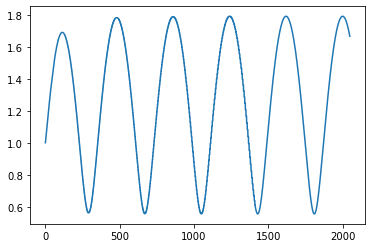

In [418]:
fs = np.arange(0.25, 2048, 1/4)
ys_grid = np.logspace(-2, np.log10(5), 35000)
ws_grid = np.logspace(-4, np.log10(1.3e4), 6000)

Ffs = pnt_Ff_lookup_table(fs, 100, 0.654561, ys_grid, ws_grid)

plt.plot(fs, np.abs(Ffs))
# plt.xscale('log')
plt.show()

### 2. A2. Attempting to use lookup table using modified index finding methods 
#### Result: avg. speed ~0.07 s  :'-( 
#### (more than the previous approach)

In [425]:
def w_index(w, ws_grid):
    return np.argmin(np.abs(ws_grid - w))

def y_index(y, ws_grid):
    return np.argmin(np.abs(ys_grid - y))

def y_index_opt(y, ys_grid):
    v1 = np.log10(np.min(ys_grid))
    v2 = np.log10(np.max(ys_grid))
    d_y = (v2-v1)/len(ys_grid)
    tmp_indx = round(np.floor((np.log10(y)-v1)/d_y)) 
    if tmp_indx==len(ys_grid):
        return tmp_indx -1 
    elif tmp_indx not in [0, len(ys_grid)-1]:
        min_indx = np.argmin([np.abs(y-ys_grid[tmp_indx-1]), np.abs(y-ys_grid[tmp_indx]), np.abs(y-ys_grid[tmp_indx+1])])
        return tmp_indx -1 + min_indx
    else:
        return tmp_indx
    
def w_index_opt(w, ws_grid): #, ws_min, ws_max, d_ws
    v1 = np.log10(np.min(ws_grid))
    v2 = np.log10(np.max(ws_grid))
    d_w = (v2-v1)/len(ws_grid)
    v1, v2 = ws_min, ws_max
    d_w = d_ws
    tmp_indx = round(np.floor((np.log10(w)-v1)/d_w)) 
    if tmp_indx==len(ws_grid):
        return tmp_indx -1 
    elif tmp_indx not in [0, len(ws_grid)-1]:
        min_indx = np.argmin([np.abs(w-ws_grid[tmp_indx-1]), np.abs(w-ws_grid[tmp_indx]), np.abs(w-ws_grid[tmp_indx+1])])
        return tmp_indx -1 + min_indx
    else:
        return tmp_indx
    return tmp_indx
    
def pnt_Ff_lookup_table(fs, ml, yl, ys_grid, ws_grid):
    wfs = np.array([pnt_lens_cy.w_of_f(f, ml) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(yl)

    wfs_1 = wfs[wfs <= np.min(ws_grid)]
    Ffs_1 = np.array([1]*len(wfs_1))

    wfs_2 = wfs[(wfs > np.min(ws_grid))&(wfs <= np.max(ws_grid))]
    wfs_2_wave = wfs_2[wfs_2 <= wc]
    wfs_2_geo = wfs_2[wfs_2 > wc]

    i_y  = y_index_opt(yl, ys_grid)
    tmp_Ff_dict = Ff_grid[str(i_y)]
    i_ws = np.array([w_index_opt(w, tmp_Ff_dict['ws']) for w in wfs_2_wave])
    Ffs_2_wave = tmp_Ff_dict['Ffs_real'] + 1j*tmp_Ff_dict['Ffs_imag']
    Ffs_2_wave = Ffs_2_wave[i_ws]
    
    Ffs_2_geo = np.array([pnt_lens_cy.point_Fw_geo(w, yl) for w in wfs_2_geo])

    wfs_3 = wfs[wfs > np.max(ws_grid) ]
    Ffs_3 = np.array([pnt_lens_cy.point_Fw_geo(w, ml) for w in wfs_3])

    Ffs = np.concatenate((Ffs_1, Ffs_2_wave, Ffs_2_geo, Ffs_3))
    assert len(Ffs)==len(fs), 'len(Ffs) = {} does not match len(fs) = {}'.format(len(Ffs), len(fs))
    return Ffs     

In [426]:
t1 = time.time()
Mlzs = np.logspace(1, 4, 25)
ys = np.logspace(-2, np.log10(5), 25)
fs = np.arange(0, 1024, 1/4)
input_prms = np.array(list(product(Mlzs, ys)))

for inp in input_prms:
    Mlz, yl = inp
    Ffs = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
t2 = time.time()
print((t2-t1)/len(input_prms))

0.07232294807434082


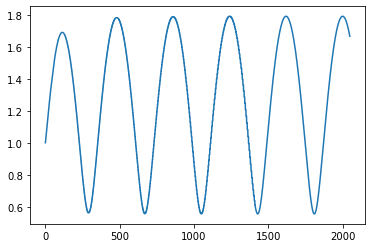

In [421]:
fs = np.arange(0.25, 2048, 1/4)
ys_grid = np.logspace(-2, np.log10(5), 35000)
ws_grid = np.logspace(-4, np.log10(1.3e4), 6000)

Ffs = pnt_Ff_lookup_table(fs, 100, 0.654561, ys_grid, ws_grid)

plt.plot(fs, np.abs(Ffs))
# plt.xscale('log')
plt.show()

In [407]:
i_ys = np.array([y_index(y, ys_grid) for y in ys_grid[:1000]])
i_ys_opt = np.array([y_index_opt(y, ys_grid) for y in ys_grid[:1000]])
np.allclose(i_ws, i_ws_opt)

True

In [408]:
i_ws = np.array([w_index(w, tmp_Ff_dict['ws']) for w in wfs_2_wave])
i_ws_opt = np.array([w_index_opt(w, tmp_Ff_dict['ws']) for w in wfs_2_wave])
np.allclose(i_ws, i_ws_opt)

True

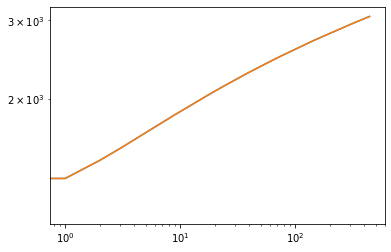

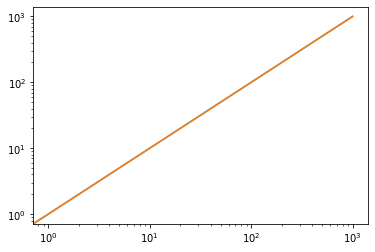

In [409]:
plt.plot(i_ws)
plt.plot(i_ws_opt)
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(i_ys)
plt.plot(i_ys_opt)
plt.xscale('log')
plt.yscale('log')
plt.show()

### 2. A3. Using interpolation on w
#### Result: avg. speed ~0.002 s   :) Yay!!! 

In [41]:
def w_index(w, ws_grid):
    return np.argmin(np.abs(ws_grid - w))

def y_index(y, ws_grid):
    return np.argmin(np.abs(ys_grid - y))

def y_index_opt(y, ys_grid):
    v1 = np.log10(np.min(ys_grid))
    v2 = np.log10(np.max(ys_grid))
    d_y = (v2-v1)/len(ys_grid)
    tmp_indx = round(np.floor((np.log10(y)-v1)/d_y)) 
    if tmp_indx==len(ys_grid):
        return tmp_indx -1 
    elif tmp_indx not in [0, len(ys_grid)-1]:
        min_indx = np.argmin([np.abs(y-ys_grid[tmp_indx-1]), np.abs(y-ys_grid[tmp_indx]), np.abs(y-ys_grid[tmp_indx+1])])
        return tmp_indx -1 + min_indx
    else:
        return tmp_indx
    
def w_index_opt(w, ws_grid, ws_min, ws_max, d_ws):
    # v1 = np.log10(np.min(ws_grid))
    # v2 = np.log10(np.max(ws_grid))
    # d_w = (v2-v1)/len(ws_grid)
    v1, v2 = ws_min, ws_max
    d_w = d_ws
    tmp_indx = round(np.floor((np.log10(w)-v1)/d_w)) 
    if tmp_indx==len(ws_grid):
        return tmp_indx -1 
    elif tmp_indx not in [0, len(ws_grid)-1]:
        min_indx = np.argmin([np.abs(w-ws_grid[tmp_indx-1]), np.abs(w-ws_grid[tmp_indx]), np.abs(w-ws_grid[tmp_indx+1])])
        return tmp_indx -1 + min_indx
    else:
        return tmp_indx
    return tmp_indx
    
def pnt_Ff_lookup_table(fs, ml, yl, ys_grid, ws_grid):
    wfs = np.array([pnt_lens_cy.w_of_f(f, ml) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(yl)

    wfs_1 = wfs[wfs <= np.min(ws_grid)]
    Ffs_1 = np.array([1]*len(wfs_1))

    wfs_2 = wfs[(wfs > np.min(ws_grid))&(wfs <= np.max(ws_grid))]
    wfs_2_wave = wfs_2[wfs_2 <= wc]
    wfs_2_geo = wfs_2[wfs_2 > wc]

    i_y  = y_index(yl, ys_grid)
    tmp_Ff_dict = Ff_grid[str(i_y)]
    #i_ws = np.array([w_index(w, tmp_Ff_dict['ws']) for w in wfs_2_wave])
    #i_ws = [0]*len(wfs_2_wave)
    #Ffs_2_wave = tmp_Ff_dict['Ffs_real'] + 1j*tmp_Ff_dict['Ffs_imag']
    #Ffs_2_wave = Ffs_2_wave[i_ws]
    ws = tmp_Ff_dict['ws']
    Ffs = tmp_Ff_dict['Ffs_real'] + 1j*tmp_Ff_dict['Ffs_imag']
    i_Ff = interp1d(ws, Ffs)
    Ffs_2_wave = i_Ff(wfs_2_wave)
    
    Ffs_2_geo = np.array([pnt_lens_cy.point_Fw_geo(w, yl) for w in wfs_2_geo])

    wfs_3 = wfs[wfs > np.max(ws_grid) ]
    Ffs_3 = np.array([pnt_lens_cy.point_Fw_geo(w, ml) for w in wfs_3])

    Ffs = np.concatenate((Ffs_1, Ffs_2_wave, Ffs_2_geo, Ffs_3))
    assert len(Ffs)==len(fs), 'len(Ffs) = {} does not match len(fs) = {}'.format(len(Ffs), len(fs))
    return Ffs     

In [42]:
t1 = time.time()
Mlzs = np.logspace(1, 4, 50)
ys = np.logspace(-2, np.log10(5), 50)
fs = np.arange(0, 1024, 1/4)
input_prms = np.array(list(product(Mlzs, ys)))

for inp in input_prms:
    Mlz, yl = inp
    Ffs = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
t2 = time.time()
print((t2-t1)/len(input_prms))

0.0016083477020263671


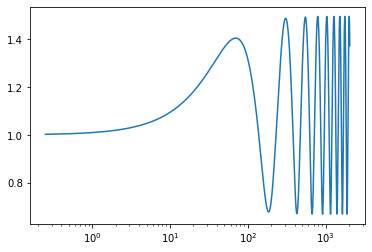

In [44]:
fs = np.arange(0.25, 2048, 1/4)
ys_grid = np.logspace(-2, np.log10(5), 35000)
ws_grid = np.logspace(-4, np.log10(1.3e4), 6000)

Ffs = pnt_Ff_lookup_table(fs, 100, 1, ys_grid, ws_grid)

plt.plot(fs, np.abs(Ffs))
plt.xscale('log')
plt.show()

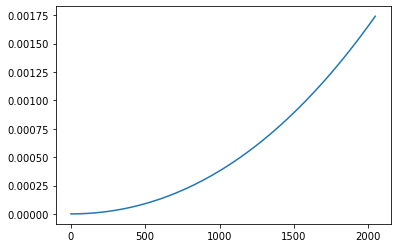

In [34]:
fs = np.arange(0.25, 2048, 1/4)
ys_grid = np.logspace(-2, np.log10(5), 35000)
ws_grid = np.logspace(-4, np.log10(1.3e4), 6000)

Ffs_1 = pnt_Ff_lookup_table(fs, 1, 0.01, ys_grid, ws_grid)
Ffs_2 = pnt_Ff_lookup_table(fs, 1, 0.3, ys_grid, ws_grid)

plt.plot(fs, np.abs(np.abs(Ffs_1)-np.abs(Ffs_2)))
# plt.xscale('log')
plt.show()

### 2. A4. Using interpolation on w + python package instead of cython
#### Result: avg. speed ~0.02 s  => 10x slower than Cython. (Therefore Cython is very important) 

In [11]:
def w_index(w, ws_grid):
    return np.argmin(np.abs(ws_grid - w))

def y_index(y, ws_grid):
    return np.argmin(np.abs(ys_grid - y))

def y_index_opt(y, ys_grid):
    v1 = np.log10(np.min(ys_grid))
    v2 = np.log10(np.max(ys_grid))
    d_y = (v2-v1)/len(ys_grid)
    tmp_indx = round(np.floor((np.log10(y)-v1)/d_y)) 
    if tmp_indx==len(ys_grid):
        return tmp_indx -1 
    elif tmp_indx not in [0, len(ys_grid)-1]:
        min_indx = np.argmin([np.abs(y-ys_grid[tmp_indx-1]), np.abs(y-ys_grid[tmp_indx]), np.abs(y-ys_grid[tmp_indx+1])])
        return tmp_indx -1 + min_indx
    else:
        return tmp_indx
    
def w_index_opt(w, ws_grid, ws_min, ws_max, d_ws):
    # v1 = np.log10(np.min(ws_grid))
    # v2 = np.log10(np.max(ws_grid))
    # d_w = (v2-v1)/len(ws_grid)
    v1, v2 = ws_min, ws_max
    d_w = d_ws
    tmp_indx = round(np.floor((np.log10(w)-v1)/d_w)) 
    if tmp_indx==len(ws_grid):
        return tmp_indx -1 
    elif tmp_indx not in [0, len(ws_grid)-1]:
        min_indx = np.argmin([np.abs(w-ws_grid[tmp_indx-1]), np.abs(w-ws_grid[tmp_indx]), np.abs(w-ws_grid[tmp_indx+1])])
        return tmp_indx -1 + min_indx
    else:
        return tmp_indx
    return tmp_indx
    
def pnt_Ff_lookup_table(fs, ml, yl, ys_grid, ws_grid):
    wfs = np.array([pnt_lens_py.w_of_f(f, ml) for f in fs])
    wc = pnt_lens_py.wc_geo_re1p0(yl)

    wfs_1 = wfs[wfs <= np.min(ws_grid)]
    Ffs_1 = np.array([1]*len(wfs_1))

    wfs_2 = wfs[(wfs > np.min(ws_grid))&(wfs <= np.max(ws_grid))]
    wfs_2_wave = wfs_2[wfs_2 <= wc]
    wfs_2_geo = wfs_2[wfs_2 > wc]

    i_y  = y_index_opt(yl, ys_grid)
    tmp_Ff_dict = Ff_grid[str(i_y)]
    #i_ws = np.array([w_index(w, tmp_Ff_dict['ws']) for w in wfs_2_wave])
    #i_ws = [0]*len(wfs_2_wave)
    #Ffs_2_wave = tmp_Ff_dict['Ffs_real'] + 1j*tmp_Ff_dict['Ffs_imag']
    #Ffs_2_wave = Ffs_2_wave[i_ws]
    ws = tmp_Ff_dict['ws']
    Ffs = tmp_Ff_dict['Ffs_real'] + 1j*tmp_Ff_dict['Ffs_imag']
    i_Ff = interp1d(ws, Ffs)
    Ffs_2_wave = i_Ff(wfs_2_wave)
    
    Ffs_2_geo = np.array([pnt_lens_py.point_Fw_geo(w, yl) for w in wfs_2_geo])

    wfs_3 = wfs[wfs > np.max(ws_grid) ]
    Ffs_3 = np.array([pnt_lens_py.point_Fw_geo(w, ml) for w in wfs_3])

    Ffs = np.concatenate((Ffs_1, Ffs_2_wave, Ffs_2_geo, Ffs_3))
    assert len(Ffs)==len(fs), 'len(Ffs) = {} does not match len(fs) = {}'.format(len(Ffs), len(fs))
    return Ffs     

In [16]:
t1 = time.time()
Mlzs = np.logspace(1, 4, 50)
ys = np.logspace(-2, np.log10(5), 50)
fs = np.arange(0, 1024, 1/4)
input_prms = np.array(list(product(Mlzs, ys)))

for inp in input_prms:
    Mlz, yl = inp
    Ffs = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
t2 = time.time()
print((t2-t1)/len(input_prms))

0.020752108573913575


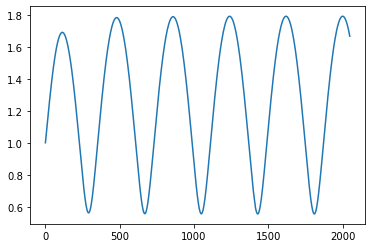

In [17]:
fs = np.arange(0.25, 2048, 1/4)
ys_grid = np.logspace(-2, np.log10(5), 35000)
ws_grid = np.logspace(-4, np.log10(1.3e4), 6000)

Ffs = pnt_Ff_lookup_table(fs, 100, 0.654561, ys_grid, ws_grid)

plt.plot(fs, np.abs(Ffs))
# plt.xscale('log')
plt.show()

### 3. Saving Interpolators on disk

In [474]:
# loading original lookup table
import pickle

outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0'

with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)

print('\nNumber of entries in lookup_table: ', len(Ff_grid))    


Number of entries in lookup_table:  35000


In [475]:
# adding interpolators to the original lookup table 
for i in range(len(Ff_grid)):
    tmp_res = Ff_grid[str(i_y)]
    tmp_ws = tmp_res['ws']
    tmp_Ffs = tmp_res['Ffs_real'] + 1j*tmp_res['Ffs_imag']
    i_Ff = interp1d(tmp_ws, tmp_Ffs)
    Ff_grid[str(i)].update(interp_Ff = i_Ff)

In [476]:
# saving everything on disk
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0_v2_with_interpolators'
t1 = time.time()
with open(outdir + label + '.pkl', 'wb') as f:
    pickle.dump(Ff_grid, f)
t2 = time.time() 
print('Computation Time (exporting) = {:.2f} s'.format(t2-t1))  


Computation Time (exporting) = 29.07 s


In [3]:
outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0_v2_with_interpolators'
with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)
    
len(Ff_grid), Ff_grid['0']

(35000,
 {'y': 0.01,
  'ws': array([1.00000000e-04, 1.00311921e-04, 1.00624816e-04, ...,
         1.29192783e+04, 1.29595763e+04, 1.30000000e+04]),
  'Ffs_real': array([ 1.00007841,  1.00007865,  1.0000789 , ..., 12.02985878,
         14.14185837, 11.91298484]),
  'Ffs_imag': array([-5.15356541e-04, -5.16807959e-04, -5.18263418e-04, ...,
         -5.01931555e+00,  7.88613724e-02,  5.14481310e+00]),
  'interp_Ff': <scipy.interpolate._interpolate.interp1d at 0x7f99304cd680>})

In [5]:
# saving only the relavant portions of lookup table to reduce size
Ff_grid_compact = dict()

for i in range(len(Ff_grid)):
    tmp_res = Ff_grid[str(i)]
    tmp_ws = tmp_res['ws']
    tmp_Ffs = tmp_res['Ffs_real'] + 1j*tmp_res['Ffs_imag']
    i_Ff = interp1d(tmp_ws, tmp_Ffs)
    Ff_grid_compact[str(i)] = dict( y=tmp_res['y'] , interp_Ff = i_Ff)
    

In [9]:
# saving the reduced lookup table on disk

label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0_v3_compact'
t1 = time.time()
with open(outdir + label + '.pkl', 'wb') as f:
    pickle.dump(Ff_grid_compact, f)
t2 = time.time() 
print('Computation Time (exporting) = {:.2f} s'.format(t2-t1))  


Computation Time (exporting) = 17.61 s


In [46]:
outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0_v3_compact'
with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)
    
len(Ff_grid), Ff_grid['0']

(35000,
 {'y': 0.01,
  'interp_Ff': <scipy.interpolate._interpolate.interp1d at 0x7fa929e8f860>})

### Conclusion: Interpolators take more space on disk than the grid themselves

## 4. Checking time with the interpolator Ff_grid
### conclusion: only a minor improvement

In [50]:
def w_index(w, ws_grid):
    return np.argmin(np.abs(ws_grid - w))

def y_index(y, ws_grid):
    return np.argmin(np.abs(ys_grid - y))
    
def pnt_Ff_lookup_table(fs, ml, yl, Ff_grid):
    wfs = np.array([pnt_lens_cy.w_of_f(f, ml) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(yl)

    wfs_1 = wfs[wfs <= np.min(ws_grid)]
    Ffs_1 = np.array([1]*len(wfs_1))

    wfs_2 = wfs[(wfs > np.min(ws_grid))&(wfs <= np.max(ws_grid))]
    wfs_2_wave = wfs_2[wfs_2 <= wc]
    wfs_2_geo = wfs_2[wfs_2 > wc]

    i_y  = y_index(yl, ys_grid)
    i_Ff = Ff_grid[str(i_y)]['interp_Ff']
    Ffs_2_wave = i_Ff(wfs_2_wave)
    
    Ffs_2_geo = np.array([pnt_lens_cy.point_Fw_geo(w, yl) for w in wfs_2_geo])

    wfs_3 = wfs[wfs > np.max(ws_grid) ]
    Ffs_3 = np.array([pnt_lens_cy.point_Fw_geo(w, ml) for w in wfs_3])

    Ffs = np.concatenate((Ffs_1, Ffs_2_wave, Ffs_2_geo, Ffs_3))
    assert len(Ffs)==len(fs), 'len(Ffs) = {} does not match len(fs) = {}'.format(len(Ffs), len(fs))
    return Ffs     

In [55]:
t1 = time.time()
Mlzs = np.logspace(1, 4, 50)
ys = np.logspace(-2, np.log10(5), 50)
fs = np.arange(0, 1024, 1/4)
input_prms = np.array(list(product(Mlzs, ys)))

for inp in input_prms:
    Mlz, yl = inp
    Ffs = pnt_Ff_lookup_table(fs, Mlz, yl, Ff_grid)
t2 = time.time()
print((t2-t1)/len(input_prms))

0.0015452920913696289
